# Presentation 3

### Objectives and Concerns: 

#### 1. Distinguish stroma from background    

#### 2. Otsu's threshold is losing parts of the epithelium

#### 3. Now able to include parts of the stroma during epithelium extraction

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import threshold_otsu
from scipy.ndimage import gaussian_filter

## Starting Point

/var/folders/35/_36mcwyx2kv5hgjlm3qr6sym0000gn/T/ipykernel_23979/3617889945.py:11: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (5777, 4549, 3) looks like that of an RGB image.
  threshold_value = threshold_otsu(smoothed_image)


Otsu's Threshold: 177


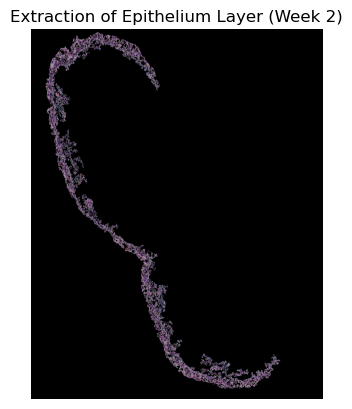

True

In [46]:
image = "HighQualitySample.tif"

def go(image):
    
    img = Image.open(image)
    img = np.array(img, dtype = np.uint8)
    smoothed_image = gaussian_filter(img, sigma=1)
    segmented_image = smoothed_image < 600

    from skimage.filters import threshold_otsu
    threshold_value = threshold_otsu(smoothed_image)
    print("Otsu's Threshold:", threshold_value)
    
    segmented_image = smoothed_image < threshold_value
    unmasked_image = np.zeros_like(img)
    unmasked_image[segmented_image] = img[segmented_image]
    
    hsv_image = cv2.cvtColor(unmasked_image, cv2.COLOR_BGR2HSV)
    lower_dark_purple = np.array([140, 55, 40])  # Saturation input seems to be the most important
    upper_dark_purple = np.array([160, 255, 150])
    purple_mask = cv2.inRange(hsv_image, lower_dark_purple, upper_dark_purple)

    kernel = np.ones((15, 15), np.uint8)
    closed_mask = cv2.morphologyEx(purple_mask, cv2.MORPH_CLOSE, kernel)
    dilated_mask = cv2.dilate(closed_mask, kernel, iterations=1)
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    min_contour_area = 50000
    large_contour_mask = np.zeros_like(purple_mask)
    for contour in contours:
        if cv2.contourArea(contour) > min_contour_area:
            cv2.drawContours(large_contour_mask, [contour], -1, 255, thickness=cv2.FILLED)

    filtered_image = cv2.bitwise_and(unmasked_image, unmasked_image, mask = large_contour_mask)
    plt.imshow(filtered_image, cmap='gray')
    plt.title("Extraction of Epithelium Layer (Week 2)")
    plt.axis('off')
    plt.show()
    
    return filtered_image

cv2.imwrite('Progress after Presentation 2.tif', go(image))

## Superpixel Segmentation

### STEP 1

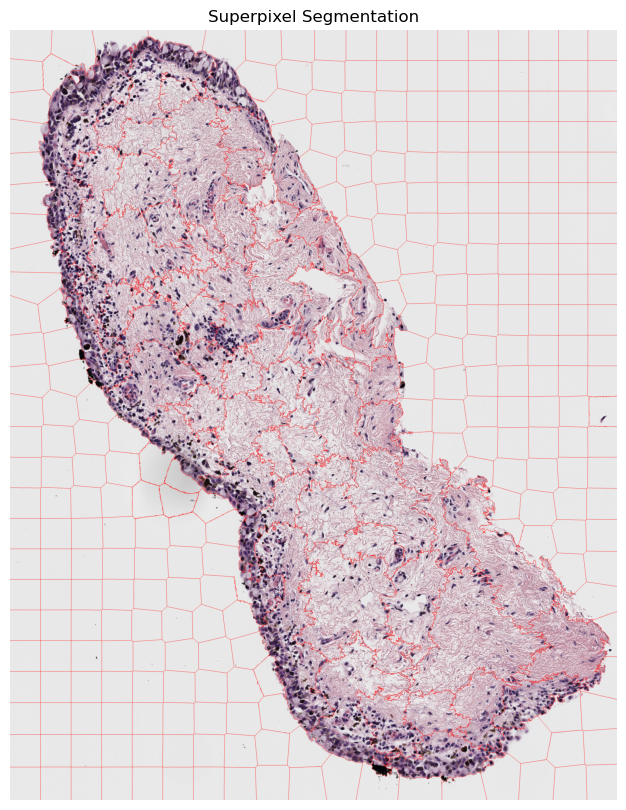

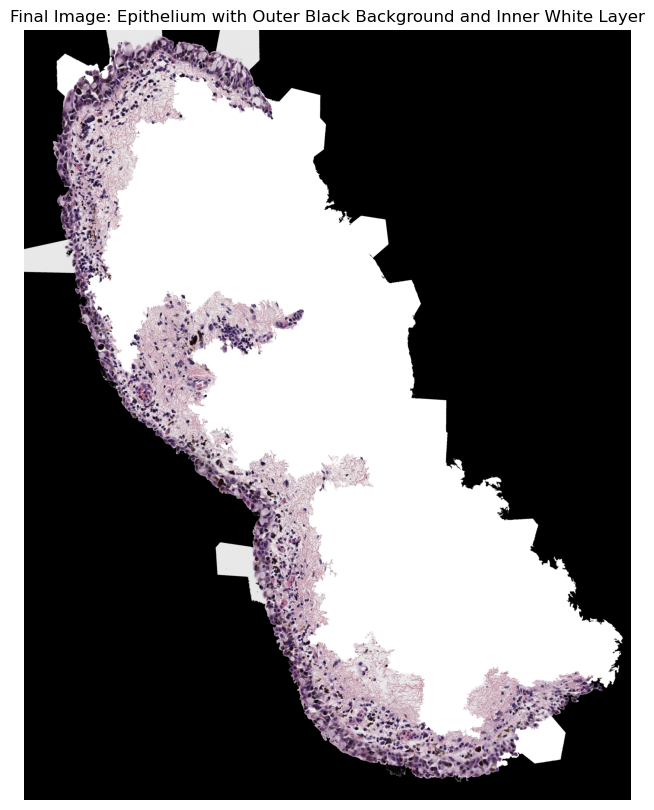

True

In [42]:
def visualize_superpixels(image_path, num_segments=500):

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Superpixel segmentation
    segments = slic(image_rgb, n_segments=num_segments, compactness=10, start_label=1)
    
    # Visualize the segments
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(mark_boundaries(image_rgb, segments, color=(1, 0, 0)))
    ax.set_title("Superpixel Segmentation")
    plt.axis('off')
    plt.show()
    
    return image_rgb, segments

# Example usage:
image_rgb, segments = visualize_superpixels('HighQualitySample.tif')

# Initialize the output image with a black background
output_image = np.zeros_like(image_rgb)

lower_dark_purple = np.array([125, 40, 40])
upper_dark_purple = np.array([155, 255, 255])

# Loop through each segment, modify, and place back into the output image
for segment_value in np.unique(segments):
    segment_mask = (segments == segment_value)
    segment_image = np.zeros_like(image_rgb)
    segment_image[segment_mask] = image_rgb[segment_mask]
    segment_hsv = cv2.cvtColor(segment_image, cv2.COLOR_RGB2HSV)

    purple_mask = cv2.inRange(segment_hsv, lower_dark_purple, upper_dark_purple)
    
    # Number of non-black pixels in the segment
    total_pixels = np.sum(segment_image[:, :, 0] > 0)
    
    # Number of purple pixels in the segment
    purple_pixels = np.sum(purple_mask > 0)
    
    # Calculate purple concentration
    purple_concentration = purple_pixels / total_pixels if total_pixels > 0 else 0    
    
    if purple_concentration > 0.15:  # High concentration of purple, keep original
        output_image[segment_mask] = image_rgb[segment_mask]
    elif purple_concentration > 0.015:  # Light purple (stroma), convert to white
        output_image[segment_mask] = [255, 255, 255]
    else:  # Barely any purple, turn black
        output_image[segment_mask] = [0, 0, 0]  # Keep segment black

plt.figure(figsize=(10, 10))
plt.imshow(output_image)
plt.title('Final Image: Epithelium with Outer Black Background and Inner White Layer')
plt.axis('off')
plt.show()


cv2.imwrite('IntermediateImage.tif', output_image)

### STEP 2

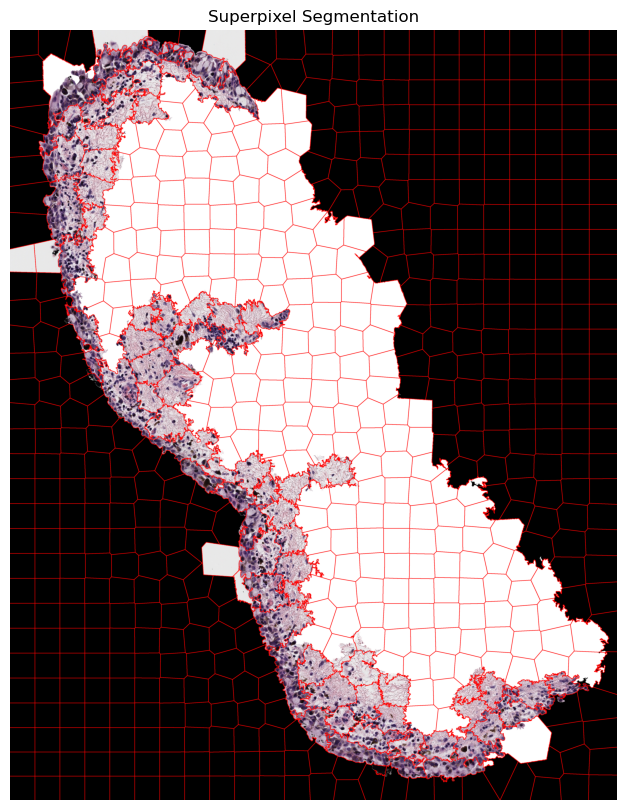

True

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries

def visualize_superpixels2(image_path, num_segments=750):  # Increase number of segments
    image = cv2.imread(image_path)
    
    # Apply Superpixel segmentation
    segments = slic(image, n_segments=num_segments, compactness=20, start_label=1)  # Increase compactness
    
    # Visualize the segments
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(mark_boundaries(image, segments, color=(1, 0, 0), outline_color=(1, 0, 0), mode='thick'))
    ax.set_title("Superpixel Segmentation")
    plt.axis('off')
    plt.show()
    
    # Return the image with the boundaries marked
    return mark_boundaries(image, segments, color=(1, 0, 0))

segmented_image = visualize_superpixels2('IntermediateImage.tif')

# Convert the segmented image to uint8 and BGR format
segmented_image_uint8 = (segmented_image * 255).astype(np.uint8)
segmented_image_bgr = cv2.cvtColor(segmented_image_uint8, cv2.COLOR_RGB2BGR)

cv2.imwrite('Step_2_Presentation_3.tif', segmented_image_bgr)

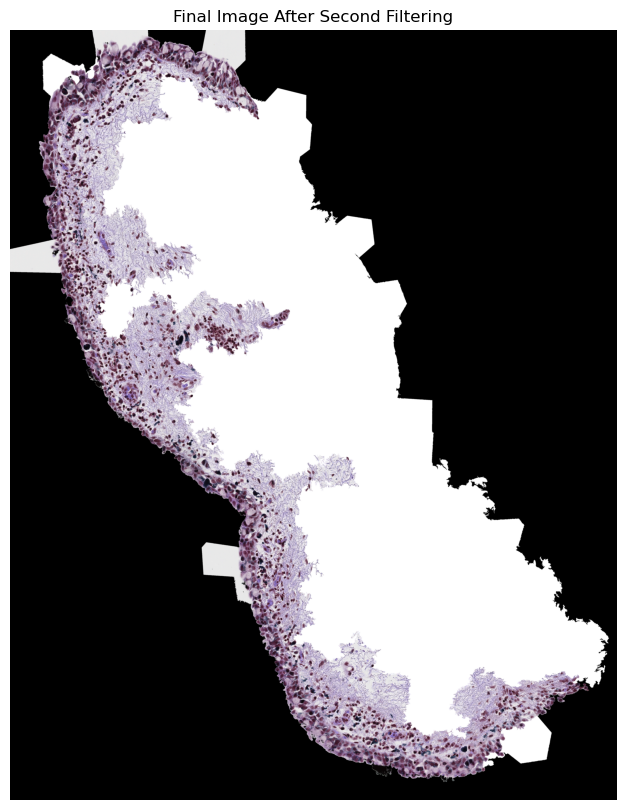

In [30]:
# Load the INTERMEDIATE image (generated by the first step)
intermediate_image = cv2.imread('IntermediateImage.tif')
intermediate_image_rgb = cv2.cvtColor(intermediate_image, cv2.COLOR_BGR2RGB)

# Define HSV color ranges for light purple and light gray
lower_light_purple = np.array([125, 30, 100])
upper_light_purple = np.array([155, 150, 255])

lower_light_gray = np.array([10, 10, 180])
upper_light_gray = np.array([170, 20, 200])

# Apply Superpixel segmentation to the intermediate image
segments = slic(intermediate_image_rgb, n_segments=750, compactness=20, start_label=1)

# Second filtering step (Light gray to black, light purple to white)
for segment_value in np.unique(segments):
    segment_mask = (segments == segment_value)
    
    # Extract the segment and convert to HSV for color detection
    segment_image = np.zeros_like(intermediate_image_rgb)
    segment_image[segment_mask] = intermediate_image_rgb[segment_mask]
    # Convert to HSV for more precise color extraction
    segment_hsv = cv2.cvtColor(segment_image, cv2.COLOR_RGB2HSV)

    # Create masks for detecting light purple and light gray pixels in the segment
    light_purple_mask = cv2.inRange(segment_hsv, lower_light_purple, upper_light_purple)
    light_gray_mask = cv2.inRange(segment_hsv, lower_light_gray, upper_light_gray)

    # Nmber of non-black pixels in the segment
    total_pixels = np.sum(segment_image[:, :, 0] > 0)

    # Number of light purple and light gray pixels in the segment
    light_purple_pixels = np.sum(light_purple_mask > 0)
    light_gray_pixels = np.sum(light_gray_mask > 0)

    # Calculate concentrations
    light_purple_concentration = light_purple_pixels / total_pixels if total_pixels > 0 else 0
    light_gray_concentration = light_gray_pixels / total_pixels if total_pixels > 0 else 0

    # Modify the segment based on light purple and gray concentrations
    if light_purple_concentration > 0.60:  # High concentration of light purple, turn white
        intermediate_image_rgb[segment_mask] = [255, 255, 255]  # Set inside epithelium to white
    if light_gray_concentration > 0.90:  # Light gray segment --> turn black
        intermediate_image_rgb[segment_mask] = [0, 0, 0]
        
plt.figure(figsize=(10, 10))
plt.imshow(intermediate_image_rgb)
plt.title('Final Image After Second Filtering')
plt.axis('off')
plt.show()

## Testing color ranges to determine upper and lower boundaries

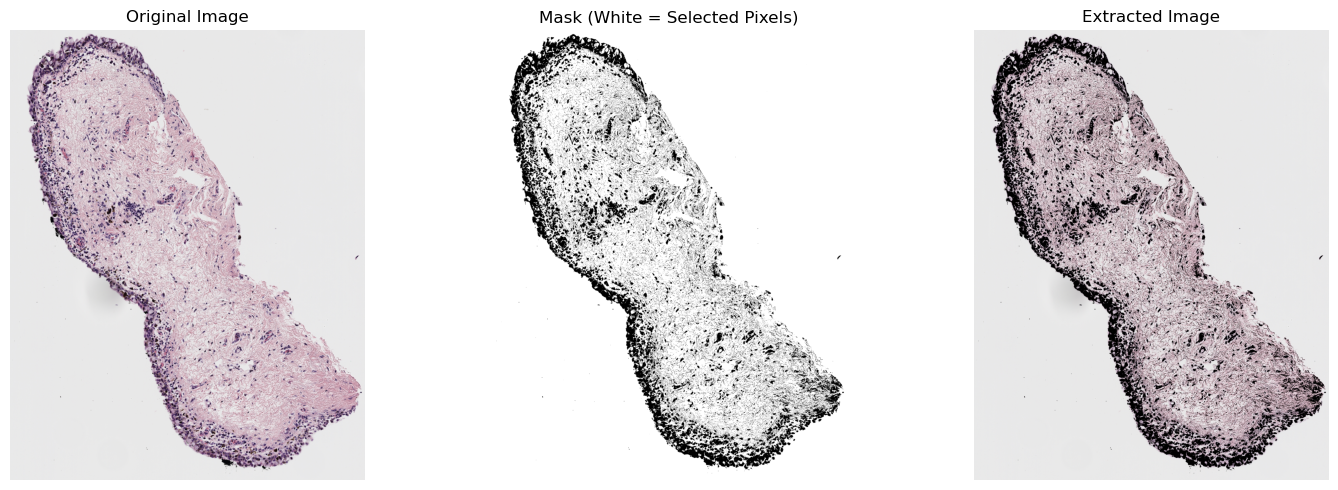

In [32]:
image_path = 'HighQualitySample.tif'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert for display
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)  # Convert to HSV for processing

# Define test HSV bounds
# I manually adjusted these values and re-ran the cell to see if there were any changes
lower_light_gray = np.array([0, 0, 180])
upper_light_gray = np.array([180, 50, 255])

#lower_bound = np.array([75, 10, 30])  # Lower bound for light purple
#upper_bound = np.array([155, 150, 255])  # Upper bound for light purple

mask = cv2.inRange(image_hsv, lower_light_gray, upper_light_gray)

extracted_image = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask, cmap='gray')
plt.title('Mask (White = Selected Pixels)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(extracted_image)
plt.title('Extracted Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Challenges and Concerns

1. Concentration thresholds are manually set and may differ across different images
2. Unable to create an algorithm that automatically obtains the masking lower and upper limits
3. Cleaning up parts of the stroma that are not adjacent to the epithelium layer
    - Possibility: identify another way to filter out problematic segments